# Setup

### Imports

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import time
from sklearn.metrics import mean_squared_error as mse
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
# env.render()
sns.set_style('whitegrid')

### Initialisations

In [2]:
n_states = 40
episodes = 10
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99 # discount future rewards
max_stps = 300
epsilon = 0.05 # probability to explore the space and not take a greedy action
env = env.unwrapped
env.seed()
np.random.seed(0)

### Quantize the states

In [3]:
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    return ((obs - env_low) / env_den).astype(int)

### Hill climb function using discretized Q table

In [4]:
def runHillClimb_Qtable(env, episodes, q_table, min_lr = 0.005, initial_lr = 1.0, gamma = 0.99, epsilon = 0.05):
    ep_steps = list()
    q_table = q_table.copy()
    print_every = int(episodes * 0.1)
    tq = tqdm(range(episodes))
    failed = 0
#     for episode in tqdm(range(episodes)):
    for episode in tq:
        tq.set_postfix(failed = failed)
        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
            pos, vel = discretization(env, obs) # the position and velocity in our discretized space

            if np.random.uniform(low=0, high=1) < epsilon: # with epsilon prob. choose random action
                a = np.random.choice(env.action_space.n)
            else: # 1 - epsilon prob of choosing greedy policy
                a = np.argmax(q_table[pos][vel])

            obs, reward, terminate,_ = env.step(a)
            total_reward += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs)
            # Q function update
            #
            q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
            steps += 1

            if terminate:
                ep_steps.append(steps)
                break
                
            if steps > 3000:
                ep_steps.append(steps)
                failed += 1
                tq.set_postfix(failed = failed)
                break
    
    return q_table, ep_steps

### Create the Q matrix with state and action as rows and y the target values from q_table

In [5]:
def createData(env, n_states = 40, discrete = True, one_hot = True):
    env_low = env.observation_space.low
    env_high = env.observation_space.high

    ls = np.linspace(env_low, env_high, n_states).T
    X = np.array(np.meshgrid(ls[0], ls[1], range(env.action_space.n))).T.reshape(-1,3).round(3)
    
    y = list()
    for i in range(len(X)):
        pos, vel = discretization(env, X[i,:2])
        vals = q_table[pos][vel][int(X[i,2])]
        if discrete:
            X[i,:2] = np.array([pos, vel])
        y.append(vals)

    y = np.array(y).reshape(-1,1)
    if one_hot:
        X_df = pd.DataFrame(X)
        one_hots = np.array(pd.get_dummies(X_df[2]))
        X_oh = np.concatenate((X[:,:-1], one_hots), axis = 1)
        X_oh
    else:
        return X, y
    
    return X_oh, y

### Function to run RBF regression on Q matrix

In [6]:
def rbfValueFuncApprox(X, y = None, J = 1000, file = None):

    kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
    N = len(X) # num of state pairs in discretized space
    sig = np.std(X)
    c = kmeans.cluster_centers_

    
    if y is not None:
        # Construct design matrix
        U = np.zeros((N,J))
        for i in range(N):
            U[i] = np.exp(-np.linalg.norm((X[i] - c)/sig, axis = 1))
#             for j in range(J):
#                 U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])/sig) # Transform using RBF kernel

        w = np.linalg.inv(U.T @ U) @ U.T @ y # pseudo inverse solution for optimal weights
        yh = U @ w # prediction of value


        # plot the true vs. prediction ----
        fig = plt.figure()
        plt.scatter(y, yh, label = 'Predicted value')
        plt.plot([y.min(),y.max()], [y.min(),y.max()], c = 'r', label = 'Perfect prediction')
        plt.xlabel('True value from discretized q-table')
        plt.ylabel('RBF estimated value')
        plt.title(f'J = {J}')
        plt.legend()
        
        if file is not None:
            fig.savefig(file)

        return U, w, yh, kmeans, sig
    
    return kmeans, sig

### Hill climb function using the RBF function approximation

In [7]:
def runHillClimb_rbf(env, episodes, w, kmeans, sig, min_lr = 0.005, initial_lr = 1.0, gamma = 0.99, epsilon = 0.05, greedy = True, render = False):
    J = len(w)
    ep_steps = list()
    for episode in tqdm(range(episodes)):
        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
            if render:
                env.render()
            pos, vel = discretization(env, obs)

            arr = np.array([[pos, vel, 1, 0, 0],
                           [pos, vel, 0, 1, 0],
                           [pos, vel, 0, 0, 1]])
            
            U_ep = createU(arr, kmeans, sig)

#             U_ep = np.zeros((3, J))
#             for i in range(3):
#                 for j in range(J):
#                     U_ep[i][j] = np.exp(-np.linalg.norm(arr[i] - kmeans.cluster_centers_[j])/sig)



            y_est = U_ep @ w
            if greedy:
                a = np.argmax(y_est)
            else:
                if np.random.uniform(low=0, high=1) < epsilon: # with epsilon prob. choose random action
                    a = np.random.choice(env.action_space.n)
                else:
                    a = np.argmax(y_est)
                



            obs, reward, terminate,_ = env.step(a)
            total_reward += abs(obs[0]+0.5)
            steps += 1
            

            if terminate or steps >= 3000:
#                 print(f'Converged in {steps} steps')
                ep_steps.append(steps)
                break
    return ep_steps

### Helper functions

In [15]:
def createU(arr, kmeans, sig):
    c = kmeans.cluster_centers_
    J = kmeans.n_clusters
    N = arr.shape[0]
    U = np.zeros((N, J))
    for i in range(N):
        U[i] = np.exp(-np.linalg.norm((arr[i] - c), axis = 1)/sig)
#         for j in range(J):
#             U[i][j] = np.exp(-np.linalg.norm(arr[i] - kmeans.cluster_centers_[j])/sig)
            
    return U

def chooseAction(vals, env, epsilon, greedy = False):
    if greedy:
        a = np.argmax(vals)
        return a
    
    else:
        if np.random.uniform(low=0, high=1) < epsilon: # with epsilon prob. choose random action
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(vals)
        return a
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### SARSA + Q-Learning

In [16]:
def runHillClimb_rbf_SARSA_Q(env, episodes, kmeans, sig, min_lr = 0.005, initial_lr = 0.1, gamma = 0.99, epsilon = 0.05, greedy = False, render = False, Q_learning = False):
    J = kmeans.n_clusters
    c = kmeans.cluster_centers_
    w = np.zeros(J)
    ep_steps = list()
    max_pos, max_vel = env.high
    min_pos, min_vel = env.low
    failed = 0
    tq = tqdm(range(episodes))
    tq.set_postfix(failed = failed)

    
#     for episode in tqdm(range(episodes)):
    for episode in tq:
        if episode % 500 == 0:
            tq.set_postfix(failed = failed, w_norm = f'{np.linalg.norm(w)} at episode {episode}')
        obs = env.reset()
        pos1, vel1 = obs
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
#         if episode % 100 == 0:
#             print(f'alpha = {alpha}')

        steps = 0
        a = np.random.choice(env.action_space.n)
        
        while True:
            if render:
                env.render()
                
            
                
            arr1 = np.array([[pos1, vel1, 1, 0, 0],
                           [pos1, vel1, 0, 1, 0],
                           [pos1, vel1, 0, 0, 1]])
            
                    
            U_ep = createU(arr1, kmeans, sig)
            
                    
            q_hat = np.dot(U_ep[a], w)
            q_hat_grad = U_ep[a]
            

            
            obs, reward, terminate,_ = env.step(a)
            pos2, vel2 = obs


            if terminate:
                w += alpha*(reward - q_hat) * q_hat_grad
                ep_steps.append(steps + 1)
                break
                                
            
            arr2 = np.array([[pos2, vel2, 1, 0, 0],
                           [pos2, vel2, 0, 1, 0],
                           [pos2, vel2, 0, 0, 1]])
            
            
            U_ep = createU(arr2, kmeans, sig)
            
            
            vals = np.dot(U_ep, w)
            
            
            a_prime = chooseAction(vals, env, epsilon, greedy)
            
                    
            
#             arr2 = np.array([[pos2, vel2, 1, 0, 0],
#                            [pos2, vel2, 0, 1, 0],
#                            [pos2, vel2, 0, 0, 1]])
            
                    
#             U_ep = createU(arr2, kmeans, sig)
            
            if Q_learning:
                q_hat_prime = vals.max()
            else:
                q_hat_prime = np.dot(U_ep[a_prime], w)

            w += alpha*(reward + gamma*q_hat_prime - q_hat)*q_hat_grad
            
            
            a = a_prime
            pos1, vel1 = pos2, vel2
            

            total_reward += abs(obs[0]+0.5)
            steps += 1            

            if terminate or steps > 3000:
                failed += 1
                tq.set_postfix(failed = failed, w_norm = f'{np.linalg.norm(w)} ({episode})')
#                 print('Did not converge: ', np.linalg.norm(w))
                ep_steps.append(steps)
                break
                
    return w, ep_steps

# Execution

## Using RBF to approximate precalculated Q-table

### Calculate Q-table

In [17]:
q_table = np.zeros((n_states, n_states, env.action_space.n)) # initialise the q_table with 0's, represents no knowledge
total_steps = 0

In [18]:
q_table, ep_steps_tabular = runHillClimb_Qtable(env, 5000, q_table)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Q-matrix of states (X), values of the states and the action (y)

In [19]:
X, y = createData(env)

### Running RBF on X

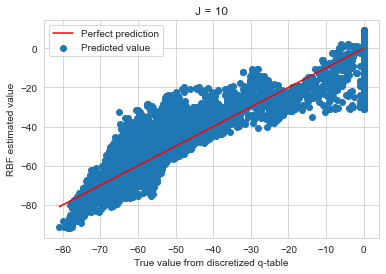

In [20]:
U_10, w_10, yh_10, kmeans_10, sig = rbfValueFuncApprox(X, y, J = 10)

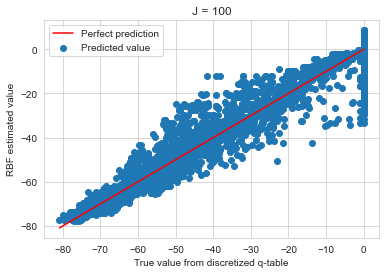

In [21]:
U_100, w_100, yh_100, kmeans_100, sig = rbfValueFuncApprox(X, y, J = 100)

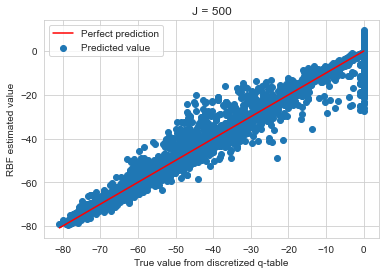

In [22]:
U_500, w_500, yh_500, kmeans_500, sig = rbfValueFuncApprox(X, y, J = 500)

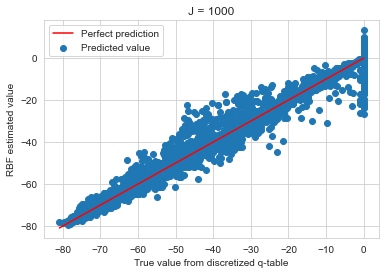

In [23]:
U_1000, w_1000, yh_1000, kmeans_1000, sig = rbfValueFuncApprox(X, y, J = 1000)

### Running the environment

In [24]:
ren = False
ep_steps = runHillClimb_rbf(env, 5000, w_500, kmeans_500, sig, greedy = False, render = ren)
if ren:
    time.sleep(1)
    env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

## Updating the weights of RBF online using SARSA and Q-learning

In [8]:
X_cont, _ = createData(env, discrete=False, one_hot=True)

NameError: name 'q_table' is not defined

In [26]:
kmeans_100_cont, sig_cont = rbfValueFuncApprox(X_cont, y=None, J = 100)

In [27]:
kmeans_1000_cont, sig_cont = rbfValueFuncApprox(X_cont, y=None, J = 1000)

### SARSA/Q-Learning

Use `greedy = False` as an $\epsilon$-greedy policy is used

In [28]:
ren = False
w_sarsa, episode_steps_sarsa = runHillClimb_rbf_SARSA_Q(env, 5000, kmeans_100_cont, sig_cont, render = ren, Q_learning = False)
if ren:
    time.sleep(1)
    env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [29]:
ren = False
w_Q, episode_steps_Q = runHillClimb_rbf_SARSA_Q(env, 5000, kmeans_100_cont, sig_cont, render = ren, Q_learning = True)
if ren:
    time.sleep(1)
    env.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

### Visualising the results

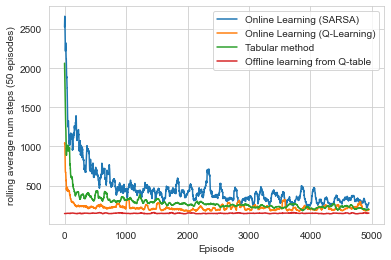

In [30]:
num_rolling = 50
m_avg_offline = moving_average(np.array(ep_steps), num_rolling)
m_avg_sarsa = moving_average(np.array(episode_steps_sarsa), num_rolling)
m_avg_tab = moving_average(np.array(ep_steps_tabular), num_rolling)
m_avg_q = moving_average(np.array(episode_steps_Q), num_rolling)
plt.plot(m_avg_sarsa, label = 'Online Learning (SARSA)')
plt.plot(m_avg_q, label = 'Online Learning (Q-Learning)')
plt.plot(m_avg_tab, label = 'Tabular method')
plt.plot(m_avg_offline, label = 'Offline learning from Q-table')
plt.xlabel('Episode')
plt.ylabel(f'rolling average num steps ({num_rolling} episodes)')
plt.legend()
# plt.savefig('SARSA_Offline_steps.pdf')